In [ ]:
!pip install river
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate

from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import mutual_info_regression

import river
from river import linear_model, metrics, preprocessing, time_series, compose, evaluate, utils, ensemble, tree, optim

import openmeteo_requests
import requests_cache
from retry_requests import retry

pd.set_option('display.max_columns', 100)

# Load Compressor Data

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/TFM/data_SM1.csv'
data = pd.read_csv(file_path)

# Load Weather Data

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.7833,
	"longitude": 1.3,
	"start_date": "2023-02-27",
	"end_date": "2024-07-28",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "surface_pressure", "wind_speed_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm"],
	"wind_speed_unit": "ms",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(6).ValuesAsNumpy()
hourly_soil_temperature_7_to_28cm = hourly.Variables(7).ValuesAsNumpy()
hourly_soil_temperature_28_to_100cm = hourly.Variables(8).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(9).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_moisture_28_to_100cm = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.head()

Coordinates 41.79261779785156°N 1.3043477535247803°E
Elevation 513.0 m asl
Timezone b'Europe/Madrid' b'CET'
Timezone difference to GMT+0 3600 s


date  temperature_2m  relative_humidity_2m  \
0 2023-02-26 23:00:00+00:00          1.0765             34.663998   
1 2023-02-27 00:00:00+00:00          1.6265             34.974651   
2 2023-02-27 01:00:00+00:00          1.1265             34.960670   
3 2023-02-27 02:00:00+00:00          0.4265             34.044380   
4 2023-02-27 03:00:00+00:00          0.8765             36.760948   

   dew_point_2m  apparent_temperature  surface_pressure  wind_speed_10m  \
0    -12.823500             -5.188007        945.678650        5.353504   
1    -12.223500             -4.328067        945.234863        4.838388   
2    -12.673500             -4.789116        945.220215        4.707441   
3    -13.623500             -5.127682        945.442932        3.905125   
4    -12.273499             -3.328840        945.728699        1.500000   

   soil_temperature_0_to_7cm  soil_temperature_7_to_28cm  \
0                     4.0265                      5.7765   
1                     5.1265                      5.8265   
2                     4.3265                      5.7265   
3                     3.5765                      5.6265   
4                     3.3265                      5.4765   

   soil_temperature_28_to_100cm  soil_moisture_0_to_7cm  \
0                        5.5765                   0.279   
1                        5.5765                   0.279   
2                        5.6265                   0.278   
3                        5.6265                   0.278   
4                        5.6265                   0.277   

   soil_moisture_7_to_28cm  soil_moisture_28_to_100cm  
0                    0.225                      0.057  
1                    0.225                      0.056  
2                    0.225                      0.056  
3                    0.225                      0.056  
4                    0.225                      0.056

# Data Integration

In [ ]:
def integrate_weather_data(compressor_data, weather_data, datetime_column='temps', weather_datetime_column='date'):
    """
    Integrate hourly weather data with minute-level compressor data.

    Parameters:
    - compressor_data (pd.DataFrame): The compressor data with minute-level resolution.
    - weather_data (pd.DataFrame): The weather data with hourly resolution.
    - datetime_column (str): The datetime column in the compressor data.
    - weather_datetime_column (str): The datetime column in the weather data.

    Returns:
    - pd.DataFrame: The merged data with weather features mapped to the minute-level compressor data.
    """
    # Ensure datetime columns are in datetime format
    compressor_data[datetime_column] = pd.to_datetime(compressor_data[datetime_column])
    weather_data[weather_datetime_column] = pd.to_datetime(weather_data[weather_datetime_column])

    # Convert both datetime columns to the same timezone (UTC)
    if compressor_data[datetime_column].dt.tz is None:
        compressor_data[datetime_column] = compressor_data[datetime_column].dt.tz_localize('UTC')
    else:
        compressor_data[datetime_column] = compressor_data[datetime_column].dt.tz_convert('UTC')

    if weather_data[weather_datetime_column].dt.tz is None:
        weather_data[weather_datetime_column] = weather_data[weather_datetime_column].dt.tz_localize('UTC')
    else:
        weather_data[weather_datetime_column] = weather_data[weather_datetime_column].dt.tz_convert('UTC')

    # Expand weather data to minute-level resolution
    weather_data = weather_data.set_index(weather_datetime_column)
    weather_data_expanded = weather_data.resample('min').ffill().reset_index()

    # Merge compressor data with expanded weather data
    merged_data = pd.merge_asof(
        compressor_data.sort_values(datetime_column),
        weather_data_expanded.sort_values(weather_datetime_column),
        left_on=datetime_column,
        right_on=weather_datetime_column,
        direction='backward'
    )

    # Drop the additional datetime column from the weather data
    merged_data.drop(columns=[weather_datetime_column], inplace=True)

    return merged_data


In [ ]:
# Integrate weather data with compressor data
data = integrate_weather_data(data, hourly_dataframe, datetime_column='temps', weather_datetime_column='date')

data.head(-5)

temps  separador-10_SM1_separador-13_SM2_modvalv  \
0      2023-02-27 00:00:00+00:00                                        0.4   
1      2023-02-27 00:01:00+00:00                                        0.4   
2      2023-02-27 00:02:00+00:00                                        0.4   
3      2023-02-27 00:03:00+00:00                                        0.4   
4      2023-02-27 00:04:00+00:00                                        0.4   
...                          ...                                        ...   
745850 2024-07-28 23:50:00+00:00                                        0.5   
745851 2024-07-28 23:51:00+00:00                                        0.5   
745852 2024-07-28 23:52:00+00:00                                        0.5   
745853 2024-07-28 23:53:00+00:00                                        0.5   
745854 2024-07-28 23:54:00+00:00                                        0.5   

        T4_CoolingP  T4_ElectricP  T3_CoolingP  T3_ElectricP  T2_CoolingP  \
0          0.000000      0.000000          0.0           0.0   567.870056   
1          0.000000      0.000000          0.0           0.0   573.448303   
2          0.000000      0.000000          0.0           0.0   574.060120   
3          0.000000      0.000000          0.0           0.0   575.971985   
4          0.000000      0.000000          0.0           0.0   581.486511   
...             ...           ...          ...           ...          ...   
745850  1042.517334    242.999893          0.0           0.0     0.000000   
745851  1079.756348    251.999893          0.0           0.0     0.000000   
745852  1133.018433    260.999878          0.0           0.0     0.000000   
745853  1265.658936    287.999878          0.0           0.0     0.000000   
745854  1244.265747    278.999878          0.0           0.0     0.000000   

        T2_ElectricP  T1_CoolingP  T1_ElectricP  Suction_P_separador-10_SM1  \
0         170.999924          0.0           1.0                       1.997   
1         171.999924          0.0           1.0                       2.007   
2         173.999924          0.0           1.0                       2.023   
3         173.999924          0.0           1.0                       1.999   
4         175.999924          0.0           1.0                       2.011   
...              ...          ...           ...                         ...   
745850      0.000000          0.0           1.0                       2.003   
745851      0.000000          0.0           1.0                       2.021   
745852      0.000000          0.0           1.0                       2.045   
745853      0.000000          0.0           1.0                       2.046   
745854      0.000000          0.0           1.0                       2.022   

        Discharge_P                        utc  T4_CoolingL  T3_CoolingL  \
0             9.961  2023-02-26 23:00:00+00:00          NaN          NaN   
1             9.899  2023-02-26 23:01:00+00:00          NaN          NaN   
2            10.008  2023-02-26 23:02:00+00:00          NaN          NaN   
3            10.116  2023-02-26 23:03:00+00:00          NaN          NaN   
4            10.066  2023-02-26 23:04:00+00:00          NaN          NaN   
...             ...                        ...          ...          ...   
745850        9.661  2024-07-28 21:50:00+00:00         51.5         -0.1   
745851        9.780  2024-07-28 21:51:00+00:00         52.8         -0.1   
745852        9.784  2024-07-28 21:52:00+00:00         54.7         -0.1   
745853        9.740  2024-07-28 21:53:00+00:00         60.9         -0.1   
745854        9.679  2024-07-28 21:54:00+00:00         58.5         -0.1   

        T2_CoolingL  T1_CoolingL  temperature_2m  relative_humidity_2m  \
0               NaN          NaN        1.626500             34.974651   
1               NaN          NaN        1.626500             34.974651   
2               NaN          NaN        1.626500             34.97465

# Function creation

In [ ]:
# Prepare datetime function for a single row
def prepare_datetime_index(row, datetime_column='temps'):
    """
    Convert the specified column to datetime format.

    Parameters:
    row (pd.Series): The input row to be processed.
    datetime_column (str): The column name to convert to datetime.

    Returns:
    pd.Series: The row with the datetime column converted to datetime format.
    """
    row[datetime_column] = pd.to_datetime(row[datetime_column])
    return row


def clean_data(index, row, processed_indices):
    """
    Skip the row if the index is a duplicate, skip the row if there are any NaN values for target columns, fill NaN values with 0 for specified columns, and drop the 'utc' column if it exists.

    Parameters:
    index (Timestamp): The index of the row.
    row (pd.Series): The input row to be cleaned.
    processed_indices (set): Set of indices that have already been processed.

    Returns:
    pd.Series or None: The cleaned row, or None if the row is a duplicate or has invalid values.
    """
    # Step 1: Check if the index has already been processed (to avoid duplicates)
    if index in processed_indices:
        return None  # Skip this row if the index has already been processed

    # Step 2: Drop the row if it contains NaN values in the target columns
    if row[['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']].isna().any():
        return None  # Skip this row if any target column contains NaN

    # Step 3: Fill NaN values with 0 for specified columns
    columns_to_fill = [
        'T4_CoolingL', 'T3_CoolingL', 'T2_CoolingL', 'T1_CoolingL',
        'separador-10_SM1_separador-13_SM2_modvalv', 'Suction_P_separador-10_SM1', 'Discharge_P'
    ]
    for col in columns_to_fill:
        if col in row:
            row[col] = row[col] if not pd.isna(row[col]) else 0

    # Step 4: Drop the 'utc' column if it exists
    if 'utc' in row.index:
        row = row.drop(labels=['utc'])

    # Add the index to the processed indices set
    processed_indices.add(index)

    return row


# Define a function to replace negative values in numeric columns with 0 for a row
def clean_negative_values_numeric_row(row):
    """
    Replace negative values with 0 for numeric columns in a row that are not part of the weather data.

    Parameters:
    row (pd.Series): The input row.

    Returns:
    pd.Series: The row with negative values in numeric columns replaced by 0.
    """
    excluded_columns = hourly_dataframe.columns.tolist()
    return row.apply(lambda x: max(x, 0) if row.name not in excluded_columns and isinstance(x, (int, float)) else x)

# Function to create features for each row
def create_features_row(row):
    row['year'] = row['temps'].year
    row['quarter'] = row['temps'].quarter
    row['month'] = row['temps'].month
    row['day'] = row['temps'].day
    row['DayOfYear'] = row['temps'].dayofyear
    row['DayOfWeek'] = row['temps'].dayofweek
    row['hour'] = row['temps'].hour
    row['minute'] = row['temps'].minute
    return row

# Function to create ON/OFF features for compressors for each row
def create_compressor_state_features_row(row):
    """
    Creates ON/OFF features for compressors based on their electric power consumption.
    """
    for col in ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']:
        on_feature_name = col.replace('ElectricP', 'ON')
        row[on_feature_name] = 1 if row[col] > 0 else 0
    return row

# Function to create lag features for each row
def create_lag_features_row(row, previous_data):
    """
    Creates lagged features for time-series data of compressors.
    This function generates lagged features for each specified column. For each column,
    lagged values up to a specified number of steps (default: 10 lags) are added as new features.
    If there is insufficient previous data for creating a lag, the feature value defaults to 0.

    Parameters:
    - row (dict or Series): A single row of data representing the current state of the compressors.
    - previous_data (list of dicts or DataFrames): Historical data containing the previous rows of
      the dataset for creating lagged features.

    Returns:
    - dict or Series: The input row with additional lagged features for specified columns.

    Columns for lagging:
    - T1_CoolingP, T2_CoolingP, T3_CoolingP, T4_CoolingP
    - T1_ElectricP, T2_ElectricP, T3_ElectricP, T4_ElectricP
    - T1_CoolingL, T2_CoolingL, T3_CoolingL, T4_CoolingL
    """

    columns_to_lag = [
        'T1_CoolingP', 'T2_CoolingP', 'T3_CoolingP', 'T4_CoolingP',
        'T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP',
        'T1_CoolingL', 'T2_CoolingL', 'T3_CoolingL', 'T4_CoolingL'
    ]

    # Number of lags to create
    lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for col in columns_to_lag:
        for lag in lags:
            lagged_col_name = f'{col}_lag_{lag}'
            if len(previous_data) >= lag:
                row[lagged_col_name] = previous_data[-lag][col]
            else:
                row[lagged_col_name] = 0
    return row


def scale_and_transform_data(row):
    """
    Apply log transformation for skewed features.

    Parameters:
    row (pd.Series): The input row.

    Returns:
    pd.Series: The row with scaled and transformed features.
    """
    # Apply log transformation for skewed features
    row = row.apply(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)
    return row


def process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']):
    """
    Process each row: apply cleaning, transformations, and train the model.

    Parameters:
    index (Timestamp): Index of the row.
    row (pd.Series): The data row to be processed.
    models (dict): Dictionary of models for each target.
    previous_data (list): List to store the previous rows for lag feature creation.
    processed_indices (set): Set of indices that have been processed previously.
    results (dict): Dictionary to store the results.
    mae_history (dict): Dictionary to store MAE history.
    targets (list): List of target columns.
    """

    # Cleaning the data
    # Prepare datetime format
    row = prepare_datetime_index(row)

    # Clean the row (remove duplicates, handle NaN values, etc.)
    row = clean_data(index, row, processed_indices)
    if row is None:
        return  # Skip processing if the row is invalid or duplicate

    # Clean negative values for numeric columns
    row = clean_negative_values_numeric_row(row)


    # Feature engineering
    # Create additional features from the datetime index
    row = create_features_row(row)

    # Create ON/OFF features for compressors
    row = create_compressor_state_features_row(row)

    # Create lag features for the current row
    row = create_lag_features_row(row, previous_data)


    # Transform data
    # Apply log transformation for skewed features
    row = scale_and_transform_data(row)

    # Exclude columns not relevant to prediction
    exclude_columns = ['temps']
    features = [col for col in row.index if col not in exclude_columns + targets]

    # Step 9: Train the model and update metrics
    mae_metric = utils.Rolling(metrics.MAE(), 50)
    for target in targets:
        x = {feature: row[feature] for feature in features}
        y_true = row[target]
        y_pred = models[target].predict_one(x)
        models[target].learn_one(x, y_true)

        # Inverse transform the true and predicted values for MAE calculation
        y_true_original = np.expm1(y_true)
        y_pred_original = np.expm1(y_pred)

        # Update metrics
        mae_metric.update(y_true_original, y_pred_original)
        mae = mae_metric.get()
        mae_history[target].append(mae)

        # Print the results for each row
        print(f"Index: {index}, Target: {target}, True: {y_true_original:.4f}, Predicted: {y_pred_original:.4f}, MAE: {mae:.4f}")

        # Store the results
        results[target]['timestamp'].append(index)
        results[target]['actual'].append(y_true_original)
        results[target]['predicted'].append(y_pred_original)

    # Step 10: Add the row to previous data to keep the history for lag features
    previous_data.append(row)

# Initial Model

In [ ]:
# Model training
models = {
    'T1_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(),
        n_models=10,
        seed=42
    ),
    'T2_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(),
        n_models=10,
        seed=42
    ),
    'T3_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(),
        n_models=10,
        seed=42
    ),
    'T4_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(),
        n_models=10,
        seed=42
    )
}

# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}


In [ ]:
# Simulate streaming data processing
for index, row in data.iterrows():
  if index % 15 == 0:
    process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 727095, Target: T1_ElectricP, True: 0.0000, Predicted: 0.3781, MAE: 0.3781
Index: 727095, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1891
Index: 727095, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1260
Index: 727095, Target: T4_ElectricP, True: 430.9998, Predicted: 432.3995, MAE: 0.4445
Index: 727110, Target: T1_ElectricP, True: 0.0000, Predicted: 0.3760, MAE: 0.3760
Index: 727110, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1880
Index: 727110, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1253
Index: 727110, Target: T4_ElectricP, True: 384.9998, Predicted: 403.7882, MAE: 4.7911
Index: 727125, Target: T1_ElectricP, True: 0.0000, Predicted: 0.3746, MAE: 0.3746
Index: 727125, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1873
Index: 727125, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1249
Index: 727125, Target: T4_Ele

## Results plotting

### MAE plot

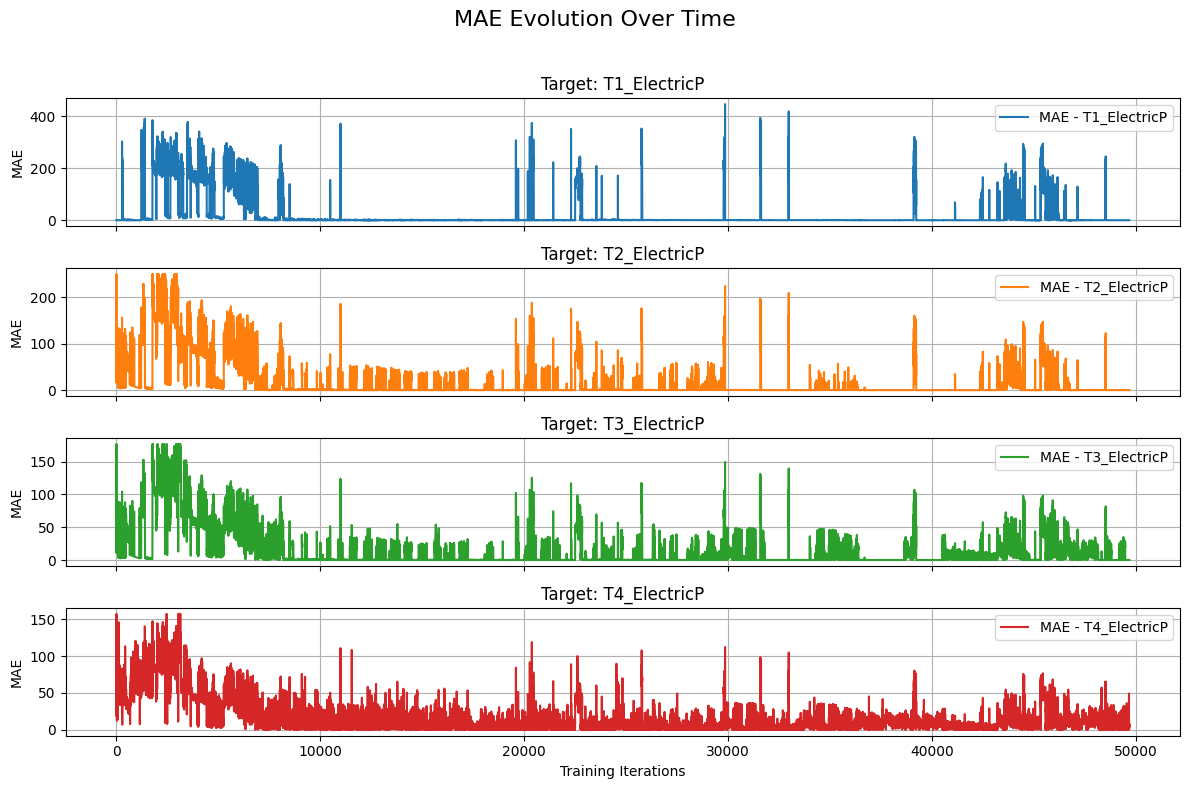

In [ ]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):
        # Calculate the IQR
        q1 = np.percentile(data, 5)
        q3 = np.percentile(data, 95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after training
plot_mae_evolution_subplots(mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

### Average MAE Table

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

# Generate the correct timestamps for the MAE history
num_iterations = len(mae_history['T1_ElectricP'])  # Assuming all targets have the same length
mae_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
mae_history_with_time = {}
for target in targets:
    mae_history_with_time[target] = pd.DataFrame({
        'timestamp': mae_timestamps,
        'mae': mae_history[target]
    })

def compute_average_mae_timeframe(mae_history_with_time, targets):
    """
    Compute average MAE over different timeframes using time-aware MAE history
    and return the result in Markdown format.
    """
    # Initialize a list to collect summary data
    summary_data = []

    for target in targets:
        target_data = mae_history_with_time[target]

        # Define the time ranges
        end_time = target_data['timestamp'].max()
        last_day = end_time - pd.Timedelta(days=1)
        last_week = end_time - pd.Timedelta(weeks=1)
        last_month = end_time - pd.Timedelta(weeks=4)
        last_6_months = end_time - pd.Timedelta(weeks=24)
        last_12_months = end_time - pd.Timedelta(weeks=48)

        # Filter and compute averages
        last_day_mae = target_data[target_data['timestamp'] >= last_day]['mae'].mean()
        last_week_mae = target_data[target_data['timestamp'] >= last_week]['mae'].mean()
        last_month_mae = target_data[target_data['timestamp'] >= last_month]['mae'].mean()
        last_6_months_mae = target_data[target_data['timestamp'] >= last_6_months]['mae'].mean()
        last_12_months_mae = target_data[target_data['timestamp'] >= last_12_months]['mae'].mean()

        # Append the results as a dictionary
        summary_data.append({
            'Target': target,
            'Last Day': last_day_mae,
            'Last Week': last_week_mae,
            'Last Month': last_month_mae,
            'Last 6 Months': last_6_months_mae,
            'Last Year': last_12_months_mae
        })

    # Convert the list of summaries into a DataFrame
    mae_summary = pd.DataFrame(summary_data).round(4)

    # Generate Markdown table using tabulate
    markdown_table = tabulate(mae_summary, headers='keys', tablefmt='pipe', showindex=False)

    # Print Markdown table
    print("### MAE Summary Table\n")
    print(markdown_table)

    # Return both the DataFrame and Markdown table
    return mae_summary, markdown_table

# Call the function
mae_summary, markdown_table = compute_average_mae_timeframe(mae_history_with_time, targets)

### MAE Summary Table

| Target       |   Last Day |   Last Week |   Last Month |   Last 6 Months |   Last Year |
|:-------------|-----------:|------------:|-------------:|----------------:|------------:|
| T1_ElectricP |     0.0803 |      0.0828 |       3.5001 |         10.1429 |      8.4408 |
| T2_ElectricP |     0.0401 |      0.0414 |       1.7501 |          6.0429 |      5.7321 |
| T3_ElectricP |     0.0268 |      4.4832 |       7.9446 |          9.1474 |      7.1561 |
| T4_ElectricP |     7.332  |     10.8243 |      11.7288 |         11.1897 |      9.2886 |


### Predictions plot

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

# Regenerate the timestamps for the correct range
correct_timestamps = pd.date_range(start=start_date, periods=len(results['T1_ElectricP']), freq=interval)

# Apply the corrected timestamps to all targets
for target in targets:
    results[target]['timestamp'] = correct_timestamps

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(targets, time_frame='hour'):
    """
    Plots 4 subplots for Actual vs Predicted values without clipping.

    Parameters:
    - targets (list): List of target variables.
    - time_frame (str): Time range to display ('hour', 'day', 'week', 'month', 'all').
    """
    end_time = max([results[target]['timestamp'].max() for target in targets])  # Find overall max timestamp

    # Determine time range based on the specified time_frame
    if time_frame == 'month':
        start_time = end_time - pd.DateOffset(months=1)
        title_suffix = "Last Month"
    elif time_frame == 'week':
        start_time = end_time - pd.DateOffset(weeks=1)
        title_suffix = "Last Week"
    elif time_frame == 'day':
        start_time = end_time - pd.DateOffset(days=1)
        title_suffix = "Last Day"
    elif time_frame == 'hour':
        start_time = end_time - pd.DateOffset(hours=6)
        title_suffix = "Last 6 Hours"
    else:
        start_time = min([results[target]['timestamp'].min() for target in targets])
        title_suffix = "Full Time Range"

    # Create 2x2 grid of subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    # Loop through targets and plot
    for i, target in enumerate(targets):
        ax = axes[i]
        target_data = results[target]

        # Filter data for the time range
        filtered_data = target_data[(target_data['timestamp'] >= start_time) & (target_data['timestamp'] <= end_time)]

        # Plot actual vs predicted values
        ax.plot(filtered_data['timestamp'], filtered_data['actual'], label='Actual', color='blue', alpha=0.7)
        ax.plot(filtered_data['timestamp'], filtered_data['predicted'], label='Predicted', color='green', linestyle='--', alpha=0.7)
        ax.set_title(f"{target} ({title_suffix})")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electric Power")
        ax.legend()
        ax.grid()

    # Adjust layout and spacing
    plt.tight_layout()
    plt.show()

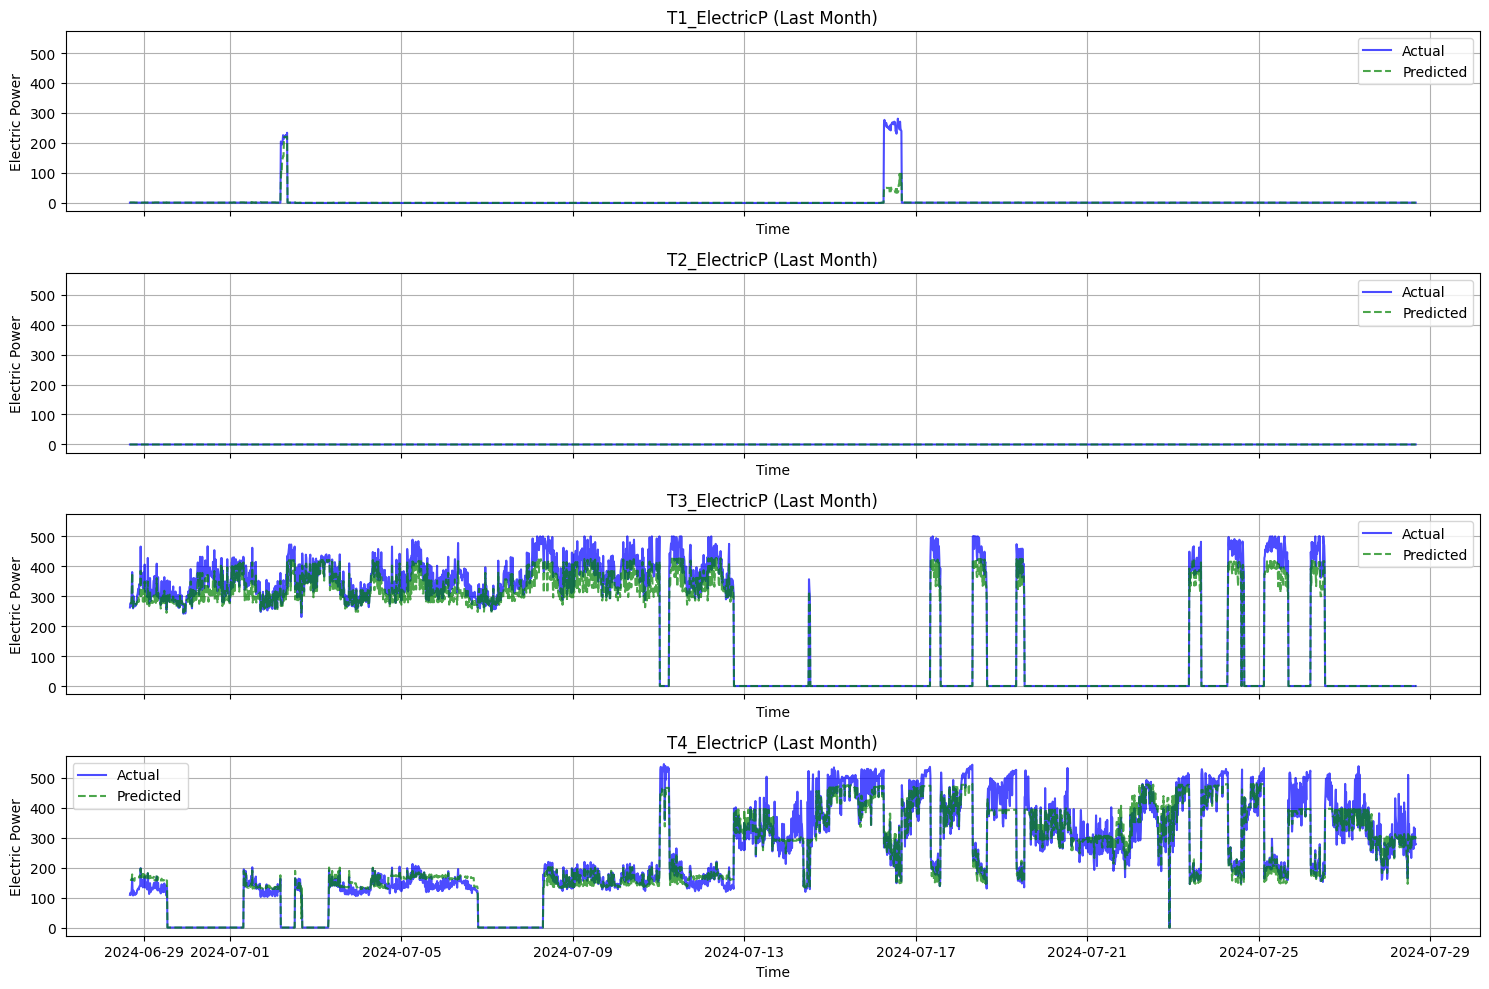

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='month')

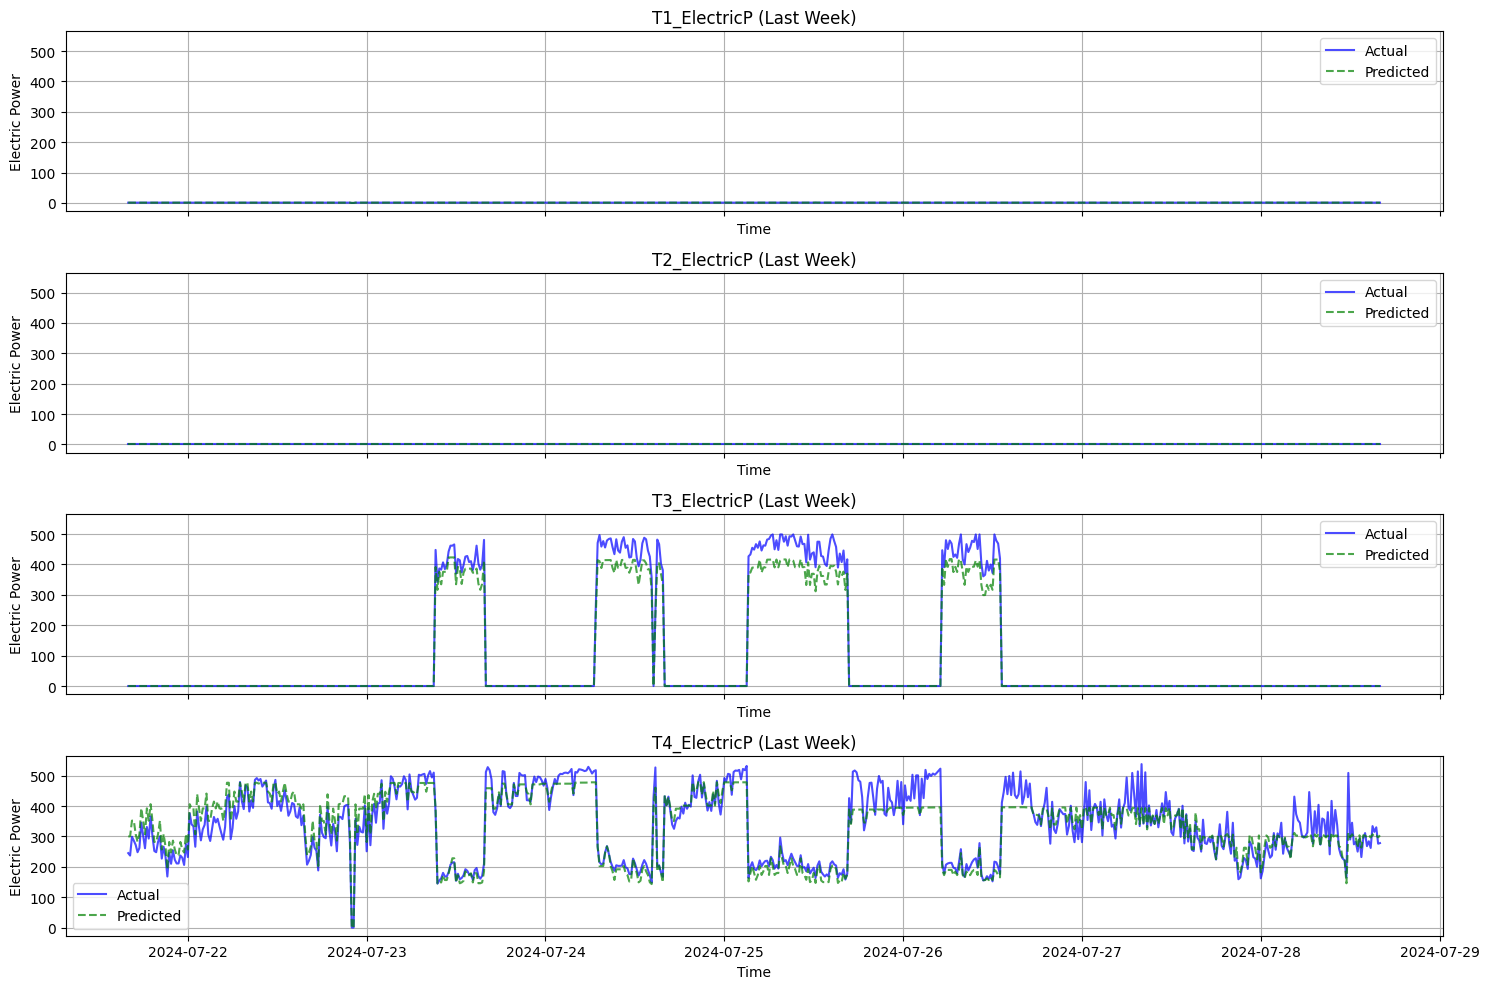

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='week')

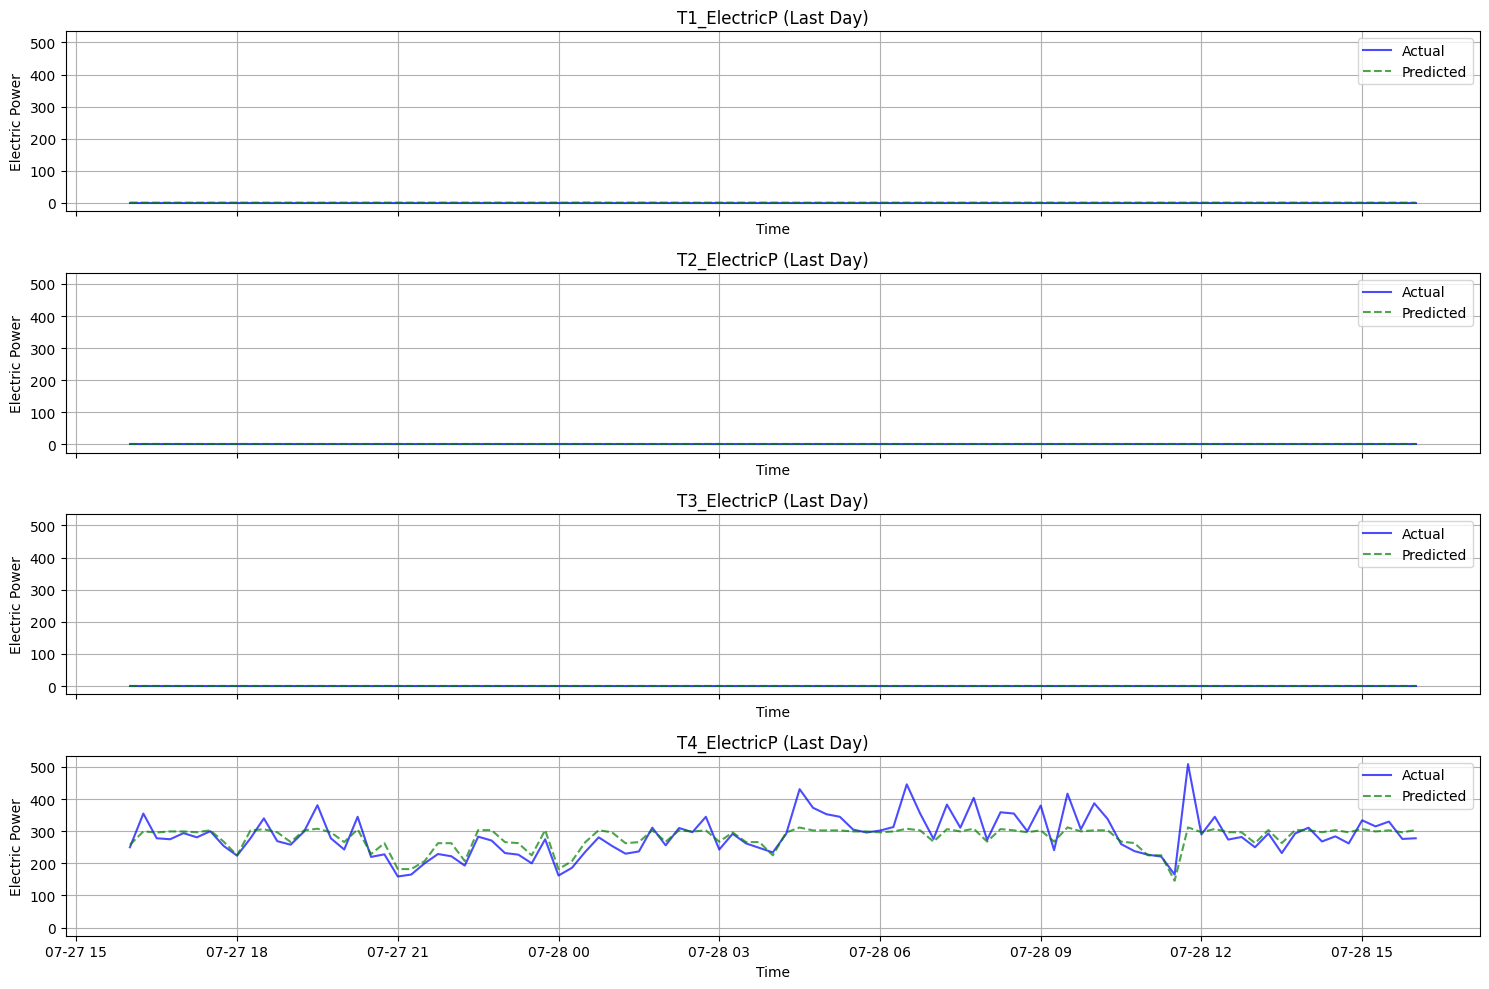

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='day')

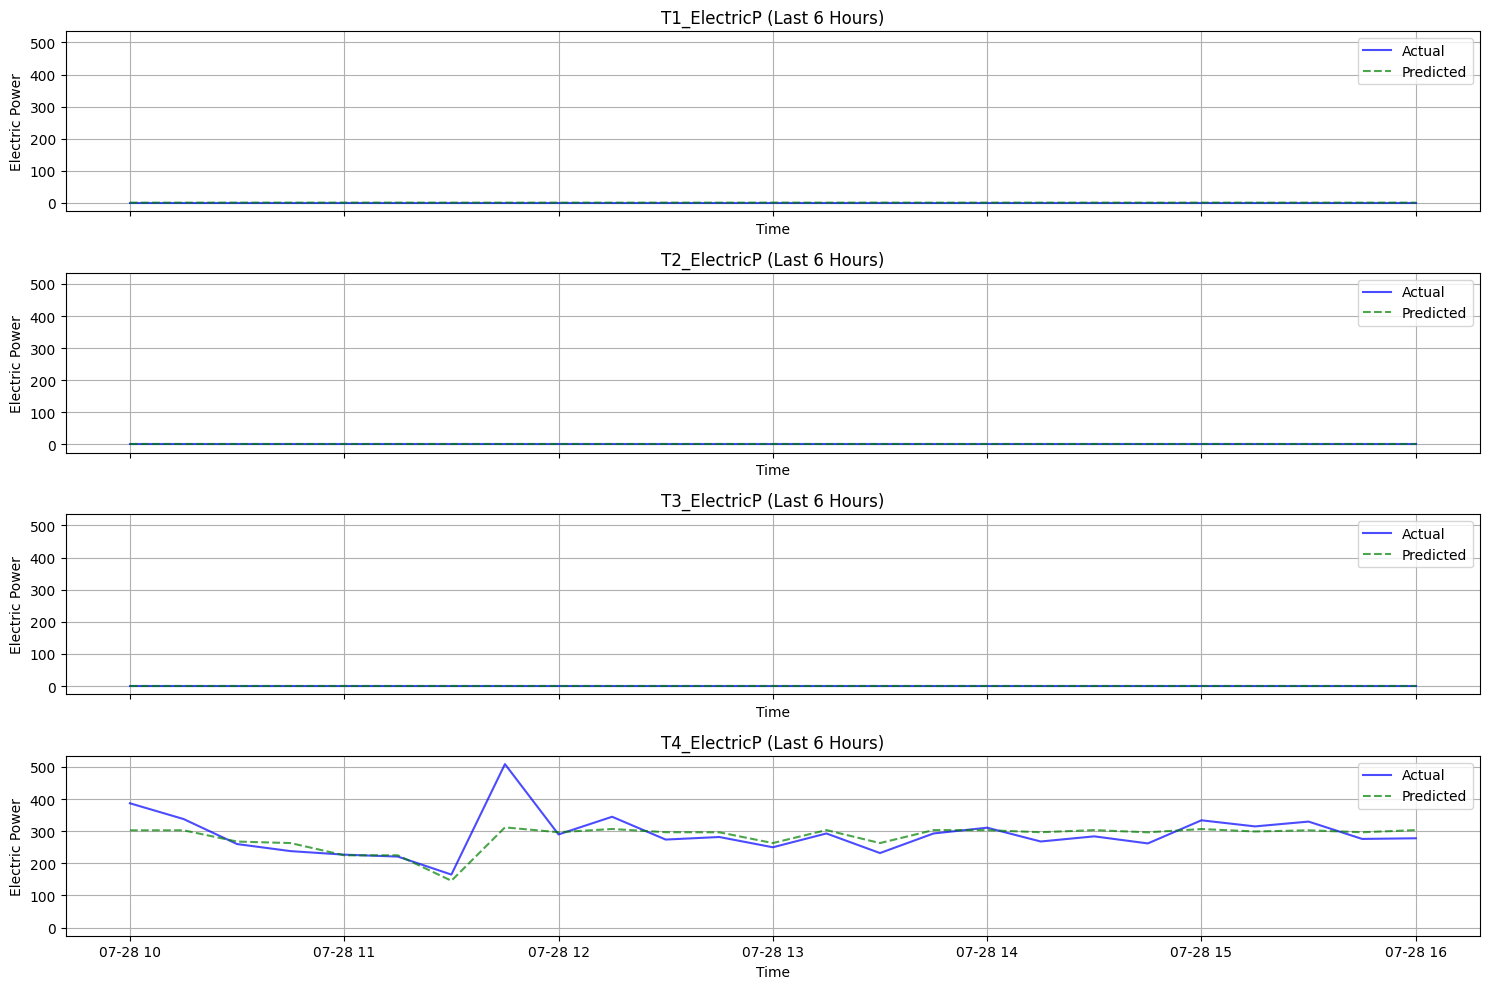

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='hour')

# Model v2.0 Hyperparameter Tuning

In [ ]:
# Model training
models = {
    'T1_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(grace_period=300, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T2_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(grace_period=300, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T3_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(grace_period=300, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T4_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(grace_period=300, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    )
}

# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}


In [ ]:
# Simulate streaming data processing
for index, row in data.iterrows():
  if index % 15 == 0:
    process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 727095, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4787, MAE: 0.4787
Index: 727095, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2394
Index: 727095, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.1596
Index: 727095, Target: T4_ElectricP, True: 430.9998, Predicted: 377.6902, MAE: 13.4471
Index: 727110, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4775, MAE: 0.4775
Index: 727110, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2388
Index: 727110, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.1592
Index: 727110, Target: T4_ElectricP, True: 384.9998, Predicted: 377.6788, MAE: 1.9496
Index: 727125, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4767, MAE: 0.4767
Index: 727125, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2384
Index: 727125, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.1589
Index: 727125, Target:

## Results plotting

### MAE plot

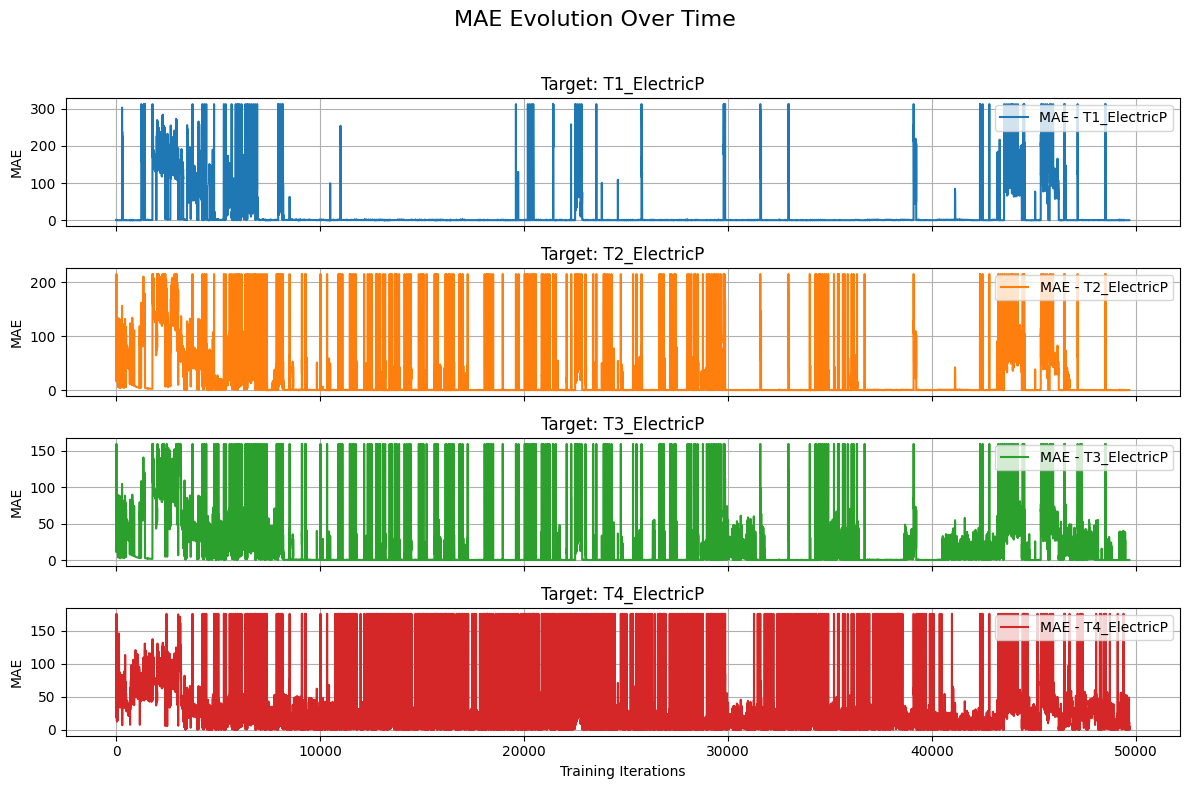

In [ ]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):
        # Calculate the IQR
        q1 = np.percentile(data, 5)
        q3 = np.percentile(data, 95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after training
plot_mae_evolution_subplots(mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

### Average MAE table

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# Generate the correct timestamps for the MAE history
num_iterations = len(mae_history['T1_ElectricP'])  # Assuming all targets have the same length
mae_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
mae_history_with_time = {}
for target in targets:
    mae_history_with_time[target] = pd.DataFrame({
        'timestamp': mae_timestamps,
        'mae': mae_history[target]
    })

def compute_average_mae_timeframe(mae_history_with_time, targets):
    """
    Compute average MAE over different timeframes using time-aware MAE history
    and return the result in Markdown format.
    """
    # Initialize a list to collect summary data
    summary_data = []

    for target in targets:
        target_data = mae_history_with_time[target]

        # Define the time ranges
        end_time = target_data['timestamp'].max()
        last_day = end_time - pd.Timedelta(days=1)
        last_week = end_time - pd.Timedelta(weeks=1)
        last_month = end_time - pd.Timedelta(weeks=4)
        last_6_months = end_time - pd.Timedelta(weeks=24)
        last_12_months = end_time - pd.Timedelta(weeks=48)

        # Filter and compute averages
        last_day_mae = target_data[target_data['timestamp'] >= last_day]['mae'].mean()
        last_week_mae = target_data[target_data['timestamp'] >= last_week]['mae'].mean()
        last_month_mae = target_data[target_data['timestamp'] >= last_month]['mae'].mean()
        last_6_months_mae = target_data[target_data['timestamp'] >= last_6_months]['mae'].mean()
        last_12_months_mae = target_data[target_data['timestamp'] >= last_12_months]['mae'].mean()

        # Append the results as a dictionary
        summary_data.append({
            'Target': target,
            'Last Day': last_day_mae,
            'Last Week': last_week_mae,
            'Last Month': last_month_mae,
            'Last 6 Months': last_6_months_mae,
            'Last Year': last_12_months_mae
        })

    # Convert the list of summaries into a DataFrame
    mae_summary = pd.DataFrame(summary_data).round(4)

    # Generate Markdown table using tabulate
    markdown_table = tabulate(mae_summary, headers='keys', tablefmt='pipe', showindex=False)

    # Print Markdown table
    print("### MAE Summary Table\n")
    print(markdown_table)

    # Return both the DataFrame and Markdown table
    return mae_summary, markdown_table

# Call the function
mae_summary, markdown_table = compute_average_mae_timeframe(mae_history_with_time, targets)

### MAE Summary Table

| Target       |   Last Day |   Last Week |   Last Month |   Last 6 Months |   Last Year |
|:-------------|-----------:|------------:|-------------:|----------------:|------------:|
| T1_ElectricP |     0.1762 |      0.1299 |     1786.37  |          371372 |      193548 |
| T2_ElectricP |     0.0881 |      0.065  |      893.187 |          266191 |      199939 |
| T3_ElectricP |     0.0587 |      4.1536 |      673.846 |          177479 |      133303 |
| T4_ElectricP |     9.2494 |   9669.1    |     3858.25  |          133788 |      100540 |


# Model v3.0. Hyperparameter tuning

In [ ]:
# Model training
models = {
    'T1_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(tau=0.03, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T2_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(tau=0.03, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T3_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(tau=0.03, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T4_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(tau=0.03, nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    )
}

# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}


In [ ]:
# Simulate streaming data processing
for index, row in data.iterrows():
  if index % 15 == 0:
    process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 727095, Target: T1_ElectricP, True: 0.0000, Predicted: 0.9774, MAE: 0.9774
Index: 727095, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.4887
Index: 727095, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3258
Index: 727095, Target: T4_ElectricP, True: 430.9998, Predicted: 366.7568, MAE: 16.3051
Index: 727110, Target: T1_ElectricP, True: 0.0000, Predicted: 0.9706, MAE: 0.9706
Index: 727110, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.4853
Index: 727110, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3235
Index: 727110, Target: T4_ElectricP, True: 384.9998, Predicted: 366.6727, MAE: 4.8244
Index: 727125, Target: T1_ElectricP, True: 0.0000, Predicted: 1.0213, MAE: 1.0213
Index: 727125, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.5106
Index: 727125, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3404
Index: 727125, Target:

## Results plotting

### MAE plot

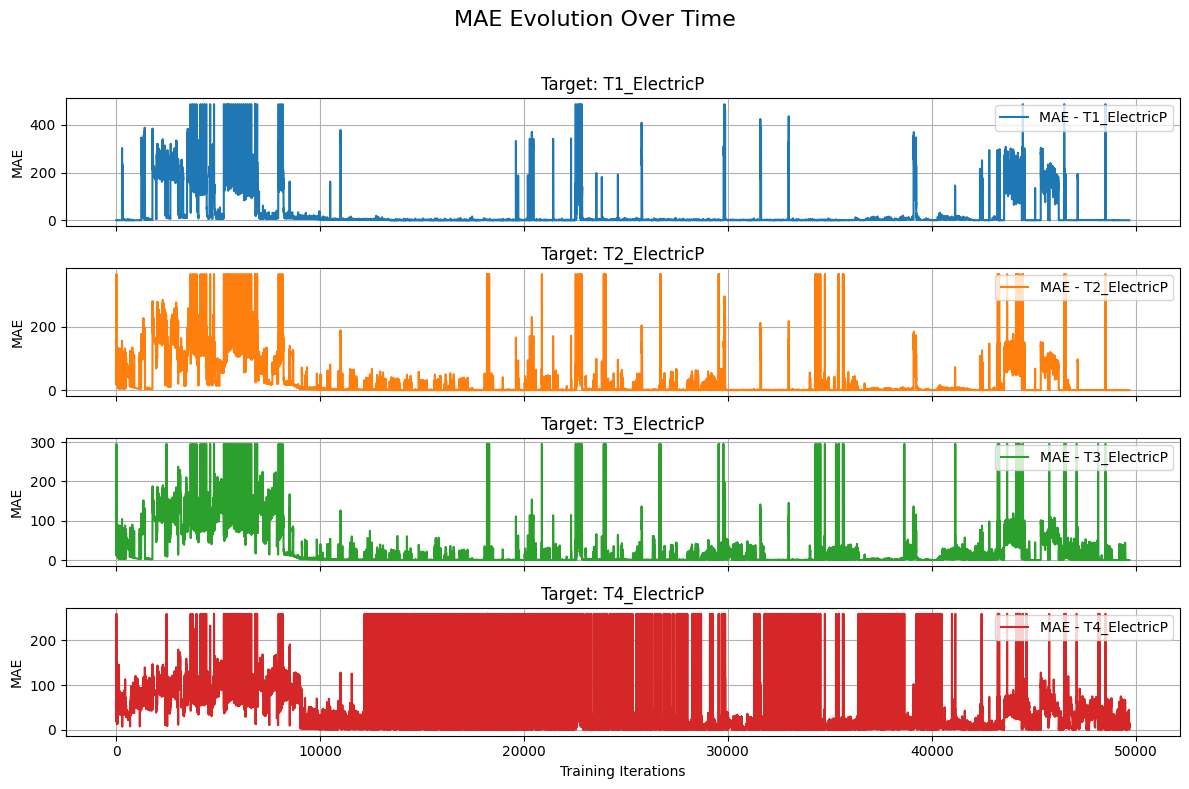

In [ ]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):
        # Calculate the IQR
        q1 = np.percentile(data, 5)
        q3 = np.percentile(data, 95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after training
plot_mae_evolution_subplots(mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

### Average MAE table

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# Generate the correct timestamps for the MAE history
num_iterations = len(mae_history['T1_ElectricP'])  # Assuming all targets have the same length
mae_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
mae_history_with_time = {}
for target in targets:
    mae_history_with_time[target] = pd.DataFrame({
        'timestamp': mae_timestamps,
        'mae': mae_history[target]
    })

def compute_average_mae_timeframe(mae_history_with_time, targets):
    """
    Compute average MAE over different timeframes using time-aware MAE history
    and return the result in Markdown format.
    """
    # Initialize a list to collect summary data
    summary_data = []

    for target in targets:
        target_data = mae_history_with_time[target]

        # Define the time ranges
        end_time = target_data['timestamp'].max()
        last_day = end_time - pd.Timedelta(days=1)
        last_week = end_time - pd.Timedelta(weeks=1)
        last_month = end_time - pd.Timedelta(weeks=4)
        last_6_months = end_time - pd.Timedelta(weeks=24)
        last_12_months = end_time - pd.Timedelta(weeks=48)

        # Filter and compute averages
        last_day_mae = target_data[target_data['timestamp'] >= last_day]['mae'].mean()
        last_week_mae = target_data[target_data['timestamp'] >= last_week]['mae'].mean()
        last_month_mae = target_data[target_data['timestamp'] >= last_month]['mae'].mean()
        last_6_months_mae = target_data[target_data['timestamp'] >= last_6_months]['mae'].mean()
        last_12_months_mae = target_data[target_data['timestamp'] >= last_12_months]['mae'].mean()

        # Append the results as a dictionary
        summary_data.append({
            'Target': target,
            'Last Day': last_day_mae,
            'Last Week': last_week_mae,
            'Last Month': last_month_mae,
            'Last 6 Months': last_6_months_mae,
            'Last Year': last_12_months_mae
        })

    # Convert the list of summaries into a DataFrame
    mae_summary = pd.DataFrame(summary_data).round(4)

    # Generate Markdown table using tabulate
    markdown_table = tabulate(mae_summary, headers='keys', tablefmt='pipe', showindex=False)

    # Print Markdown table
    print("### MAE Summary Table\n")
    print(markdown_table)

    # Return both the DataFrame and Markdown table
    return mae_summary, markdown_table

# Call the function
mae_summary, markdown_table = compute_average_mae_timeframe(mae_history_with_time, targets)

### MAE Summary Table

| Target       |   Last Day |   Last Week |   Last Month |   Last 6 Months |      Last Year |
|:-------------|-----------:|------------:|-------------:|----------------:|---------------:|
| T1_ElectricP |     0.0714 |      0.0964 |      22.26   |    29.2289      |   70.4371      |
| T2_ElectricP |     0.0357 |      0.0482 |      11.13   |  1869.74        | 3526.67        |
| T3_ElectricP |     0.0238 |      4.8237 |      53.8162 |  1657.02        | 2569.94        |
| T4_ElectricP |    15.9717 |     24.1321 |      65.0909 |     6.70357e+06 |    4.91079e+09 |


# Model v3.0. Hyperparameter tuning

In [ ]:
# Model training
models = {
    'T1_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T2_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T3_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    ),
    'T4_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(nominal_attributes=['T1_ON', 'T2_ON', 'T3_ON', 'T4_ON', 'year', 'quarter','month', 'day', 'DayOfYear', 'DayOfWeek', 'hour', 'minute']),
        n_models=10,
        seed=42
    )
}

# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}


In [ ]:
# Simulate streaming data processing
for index, row in data.iterrows():
  if index % 15 == 0:
    process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 727095, Target: T1_ElectricP, True: 0.0000, Predicted: 0.7959, MAE: 0.7959
Index: 727095, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3980
Index: 727095, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2653
Index: 727095, Target: T4_ElectricP, True: 430.9998, Predicted: 378.4859, MAE: 13.3275
Index: 727110, Target: T1_ElectricP, True: 0.0000, Predicted: 0.6787, MAE: 0.6787
Index: 727110, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3393
Index: 727110, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2262
Index: 727110, Target: T4_ElectricP, True: 384.9998, Predicted: 383.1269, MAE: 0.6379
Index: 727125, Target: T1_ElectricP, True: 0.0000, Predicted: 0.6708, MAE: 0.6708
Index: 727125, Target: T2_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.3354
Index: 727125, Target: T3_ElectricP, True: 0.0000, Predicted: -0.0000, MAE: 0.2236
Index: 727125, Target:

## Results plotting

### MAE plot

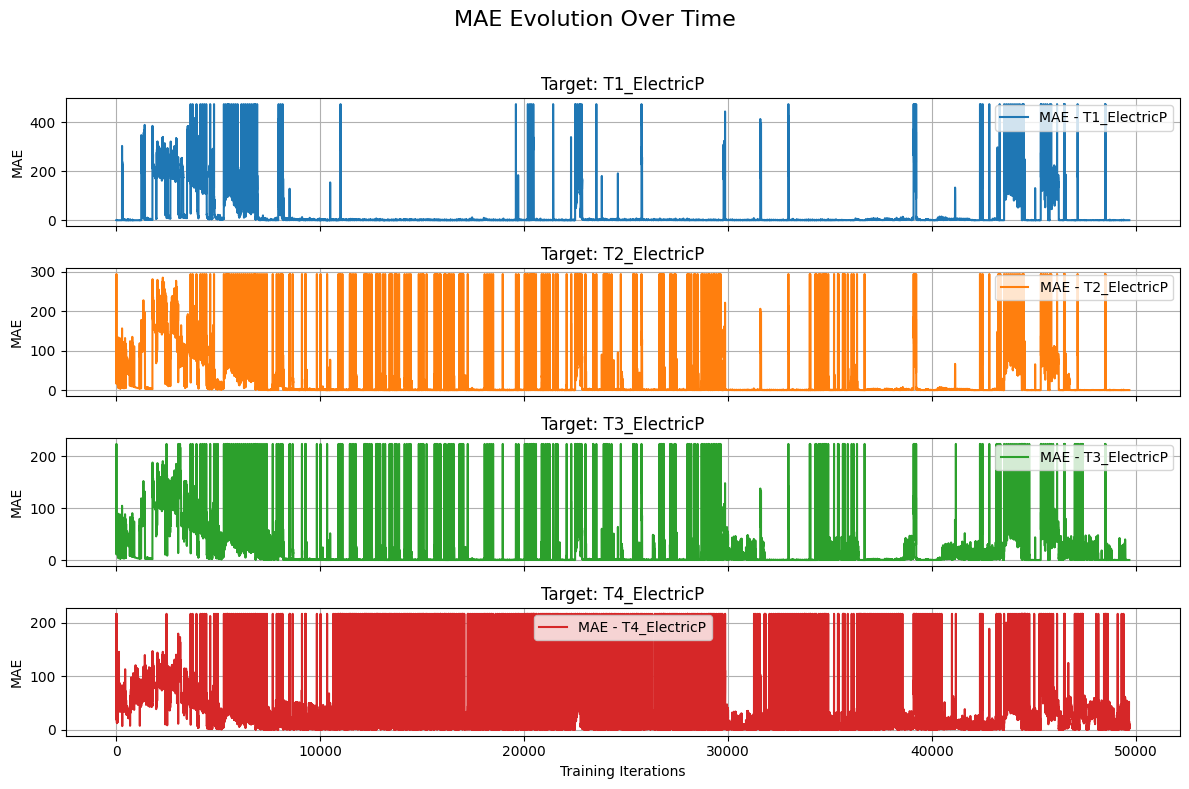

In [ ]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):
        # Calculate the IQR
        q1 = np.percentile(data, 5)
        q3 = np.percentile(data, 95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after training
plot_mae_evolution_subplots(mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

### Average MAE table

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# Generate the correct timestamps for the MAE history
num_iterations = len(mae_history['T1_ElectricP'])  # Assuming all targets have the same length
mae_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
mae_history_with_time = {}
for target in targets:
    mae_history_with_time[target] = pd.DataFrame({
        'timestamp': mae_timestamps,
        'mae': mae_history[target]
    })

def compute_average_mae_timeframe(mae_history_with_time, targets):
    """
    Compute average MAE over different timeframes using time-aware MAE history
    and return the result in Markdown format.
    """
    # Initialize a list to collect summary data
    summary_data = []

    for target in targets:
        target_data = mae_history_with_time[target]

        # Define the time ranges
        end_time = target_data['timestamp'].max()
        last_day = end_time - pd.Timedelta(days=1)
        last_week = end_time - pd.Timedelta(weeks=1)
        last_month = end_time - pd.Timedelta(weeks=4)
        last_6_months = end_time - pd.Timedelta(weeks=24)
        last_12_months = end_time - pd.Timedelta(weeks=48)

        # Filter and compute averages
        last_day_mae = target_data[target_data['timestamp'] >= last_day]['mae'].mean()
        last_week_mae = target_data[target_data['timestamp'] >= last_week]['mae'].mean()
        last_month_mae = target_data[target_data['timestamp'] >= last_month]['mae'].mean()
        last_6_months_mae = target_data[target_data['timestamp'] >= last_6_months]['mae'].mean()
        last_12_months_mae = target_data[target_data['timestamp'] >= last_12_months]['mae'].mean()

        # Append the results as a dictionary
        summary_data.append({
            'Target': target,
            'Last Day': last_day_mae,
            'Last Week': last_week_mae,
            'Last Month': last_month_mae,
            'Last 6 Months': last_6_months_mae,
            'Last Year': last_12_months_mae
        })

    # Convert the list of summaries into a DataFrame
    mae_summary = pd.DataFrame(summary_data).round(4)

    # Generate Markdown table using tabulate
    markdown_table = tabulate(mae_summary, headers='keys', tablefmt='pipe', showindex=False)

    # Print Markdown table
    print("### MAE Summary Table\n")
    print(markdown_table)

    # Return both the DataFrame and Markdown table
    return mae_summary, markdown_table

# Call the function
mae_summary, markdown_table = compute_average_mae_timeframe(mae_history_with_time, targets)

### MAE Summary Table

| Target       |   Last Day |   Last Week |   Last Month |   Last 6 Months |   Last Year |
|:-------------|-----------:|------------:|-------------:|----------------:|------------:|
| T1_ElectricP |     0.2148 |      0.1791 |      2451.52 |          181810 |     93634.6 |
| T2_ElectricP |     0.1074 |      0.0896 |      1225.76 |          101231 |    479705   |
| T3_ElectricP |     0.0716 |      3.4101 |    692462    |          188957 |    380541   |
| T4_ElectricP |    12.7146 |    154.09   |    519458    |          145564 |    332693   |


# Model v4.0 Hyperparameter Tunning

In [ ]:
# Model training
models = {
    'T1_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(max_depth=10, delta=1e-4),
        n_models=10,
        seed=42
    ),
    'T2_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(max_depth=10, delta=1e-4),
        n_models=10,
        seed=42
    ),
    'T3_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(max_depth=10, delta=1e-4),
        n_models=10,
        seed=42
    ),
    'T4_ElectricP': ensemble.BaggingRegressor(
        model=tree.HoeffdingTreeRegressor(max_depth=10, delta=1e-4),
        n_models=10,
        seed=42
    )
}

# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}


In [ ]:
# Simulate streaming data processing
for index, row in data.iterrows():
  if index % 15 == 0:
    process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 727095, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4698, MAE: 0.4698
Index: 727095, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.2349
Index: 727095, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1566
Index: 727095, Target: T4_ElectricP, True: 430.9998, Predicted: 460.0844, MAE: 7.3886
Index: 727110, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4663, MAE: 0.4663
Index: 727110, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.2332
Index: 727110, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1554
Index: 727110, Target: T4_ElectricP, True: 384.9998, Predicted: 447.7223, MAE: 15.7972
Index: 727125, Target: T1_ElectricP, True: 0.0000, Predicted: 0.4636, MAE: 0.4636
Index: 727125, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.2318
Index: 727125, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.1545
Index: 727125, Target: T4_El

## Results plotting

### MAE plot

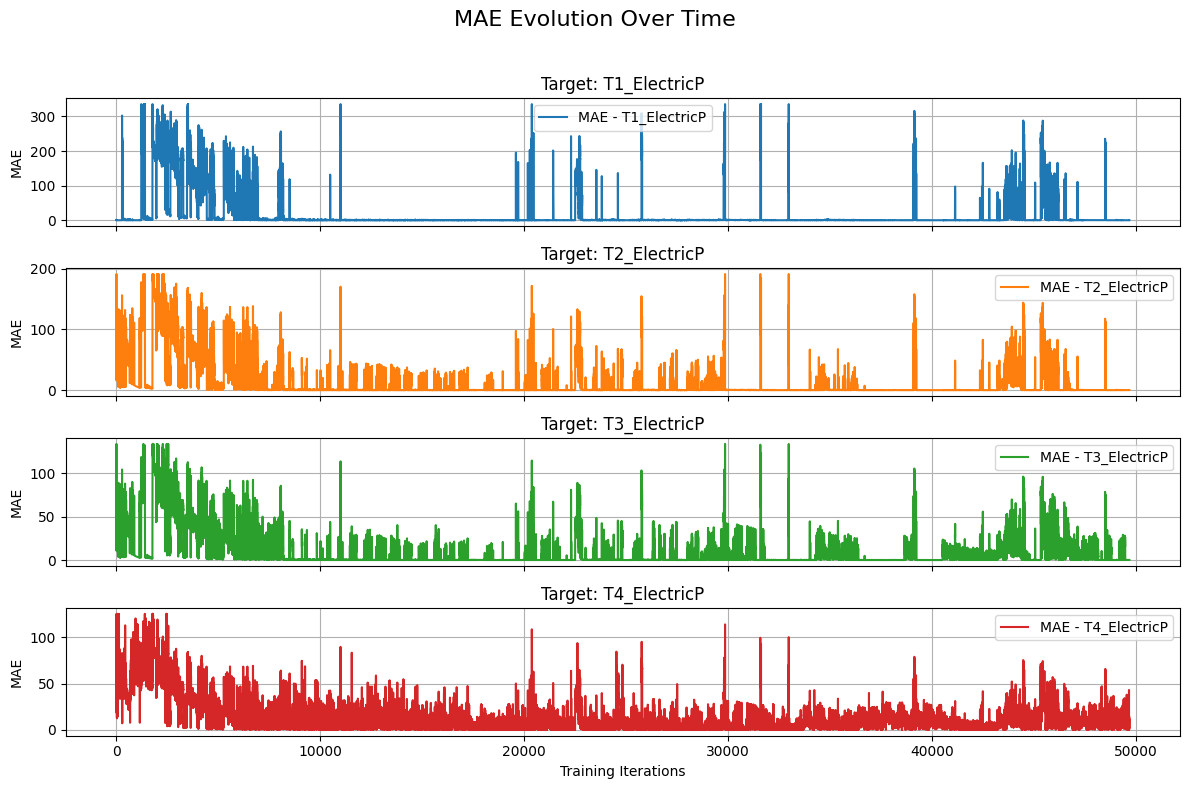

In [ ]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):
        # Calculate the IQR
        q1 = np.percentile(data, 5)
        q3 = np.percentile(data, 95)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        # Filter out outliers
        return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after training
plot_mae_evolution_subplots(mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

### Average MAE table

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']

# Generate the correct timestamps for the MAE history
num_iterations = len(mae_history['T1_ElectricP'])  # Assuming all targets have the same length
mae_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
mae_history_with_time = {}
for target in targets:
    mae_history_with_time[target] = pd.DataFrame({
        'timestamp': mae_timestamps,
        'mae': mae_history[target]
    })

def compute_average_mae_timeframe(mae_history_with_time, targets):
    """
    Compute average MAE over different timeframes using time-aware MAE history
    and return the result in Markdown format.
    """
    # Initialize a list to collect summary data
    summary_data = []

    for target in targets:
        target_data = mae_history_with_time[target]

        # Define the time ranges
        end_time = target_data['timestamp'].max()
        last_day = end_time - pd.Timedelta(days=1)
        last_week = end_time - pd.Timedelta(weeks=1)
        last_month = end_time - pd.Timedelta(weeks=4)
        last_6_months = end_time - pd.Timedelta(weeks=24)
        last_12_months = end_time - pd.Timedelta(weeks=48)

        # Filter and compute averages
        last_day_mae = target_data[target_data['timestamp'] >= last_day]['mae'].mean()
        last_week_mae = target_data[target_data['timestamp'] >= last_week]['mae'].mean()
        last_month_mae = target_data[target_data['timestamp'] >= last_month]['mae'].mean()
        last_6_months_mae = target_data[target_data['timestamp'] >= last_6_months]['mae'].mean()
        last_12_months_mae = target_data[target_data['timestamp'] >= last_12_months]['mae'].mean()

        # Append the results as a dictionary
        summary_data.append({
            'Target': target,
            'Last Day': last_day_mae,
            'Last Week': last_week_mae,
            'Last Month': last_month_mae,
            'Last 6 Months': last_6_months_mae,
            'Last Year': last_12_months_mae
        })

    # Convert the list of summaries into a DataFrame
    mae_summary = pd.DataFrame(summary_data).round(4)

    # Generate Markdown table using tabulate
    markdown_table = tabulate(mae_summary, headers='keys', tablefmt='pipe', showindex=False)

    # Print Markdown table
    print("### MAE Summary Table\n")
    print(markdown_table)

    # Return both the DataFrame and Markdown table
    return mae_summary, markdown_table

# Call the function
mae_summary, markdown_table = compute_average_mae_timeframe(mae_history_with_time, targets)

### MAE Summary Table

| Target       |   Last Day |   Last Week |   Last Month |   Last 6 Months |   Last Year |
|:-------------|-----------:|------------:|-------------:|----------------:|------------:|
| T1_ElectricP |     0.0791 |      0.1102 |       3.1686 |          8.2283 |      6.701  |
| T2_ElectricP |     0.0395 |      0.0551 |       1.5843 |          5.0971 |      4.7553 |
| T3_ElectricP |     0.0264 |      4.1141 |       6.8843 |          7.7697 |      5.8996 |
| T4_ElectricP |     6.6918 |     12.278  |      11.4505 |         10.3934 |      8.4213 |


### Predictions plot

In [ ]:
# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

# Generate the correct timestamps for the MAE history
num_iterations = len(results['T1_ElectricP'])  # Assuming all targets have the same length
target_timestamps = pd.date_range(start=start_date, periods=num_iterations, freq=interval)

# Reorganize the MAE history to include timestamps
results_with_time = {}
for target in targets:
    results_with_time[target] = pd.DataFrame({
        'timestamp': results[target]['timestamp'],
        'actual': results[target]['actual'],
        'predicted': results[target]['predicted']
    })


# Define the correct start date and interval
start_date = "2023-02-27"
interval = "15min"

# Reset the timestamps for all targets
correct_timestamps = pd.date_range(start=start_date, periods=len(results['T1_ElectricP']['actual']), freq=interval)

for target in targets:
    results[target]['timestamp'] = correct_timestamps



In [ ]:
def plot_predictions(targets, time_frame='hour'):
    """
    Plots 4 subplots for Actual vs Predicted values with the y-axis range set between 0 and 500.

    Parameters:
    - targets (list): List of target variables.
    - time_frame (str): Time range to display ('hour', 'day', 'week', 'month', 'all').
    """
    # Ensure timestamps are pandas DatetimeIndex for each target
    for target in targets:
        results[target]['timestamp'] = pd.to_datetime(results[target]['timestamp'])

    # Find the overall max timestamp
    end_time = max([results[target]['timestamp'].max() for target in targets])

    # Determine time range based on the specified time_frame
    if time_frame == 'month':
        start_time = end_time - pd.DateOffset(months=1)
        title_suffix = "Last Month"
    elif time_frame == 'week':
        start_time = end_time - pd.DateOffset(weeks=1)
        title_suffix = "Last Week"
    elif time_frame == 'day':
        start_time = end_time - pd.DateOffset(days=1)
        title_suffix = "Last Day"
    elif time_frame == 'hour':
        start_time = end_time - pd.DateOffset(hours=6)
        title_suffix = "Last 6 Hours"
    else:
        start_time = min([results[target]['timestamp'].min() for target in targets])
        title_suffix = "Full Time Range"

    # Create 2x2 grid of subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    # Loop through targets and plot
    for i, target in enumerate(targets):
        ax = axes[i]
        target_data = pd.DataFrame(results[target])  # Ensure we have a DataFrame

        # Filter data for the time range
        filtered_data = target_data[
            (target_data['timestamp'] >= start_time) & (target_data['timestamp'] <= end_time)
        ]

        # Plot actual vs predicted values
        ax.plot(filtered_data['timestamp'], filtered_data['actual'], label='Actual', color='blue', alpha=0.7)
        ax.plot(filtered_data['timestamp'], filtered_data['predicted'], label='Predicted', color='green', linestyle='--', alpha=0.7)
        ax.set_title(f"{target} ({title_suffix})")
        ax.set_xlabel("Time")
        ax.set_ylabel("Electric Power")
        ax.set_ylim(0, 500)  # Set y-axis limits
        ax.legend()
        ax.grid()

    # Adjust layout and spacing
    plt.tight_layout()
    plt.show()


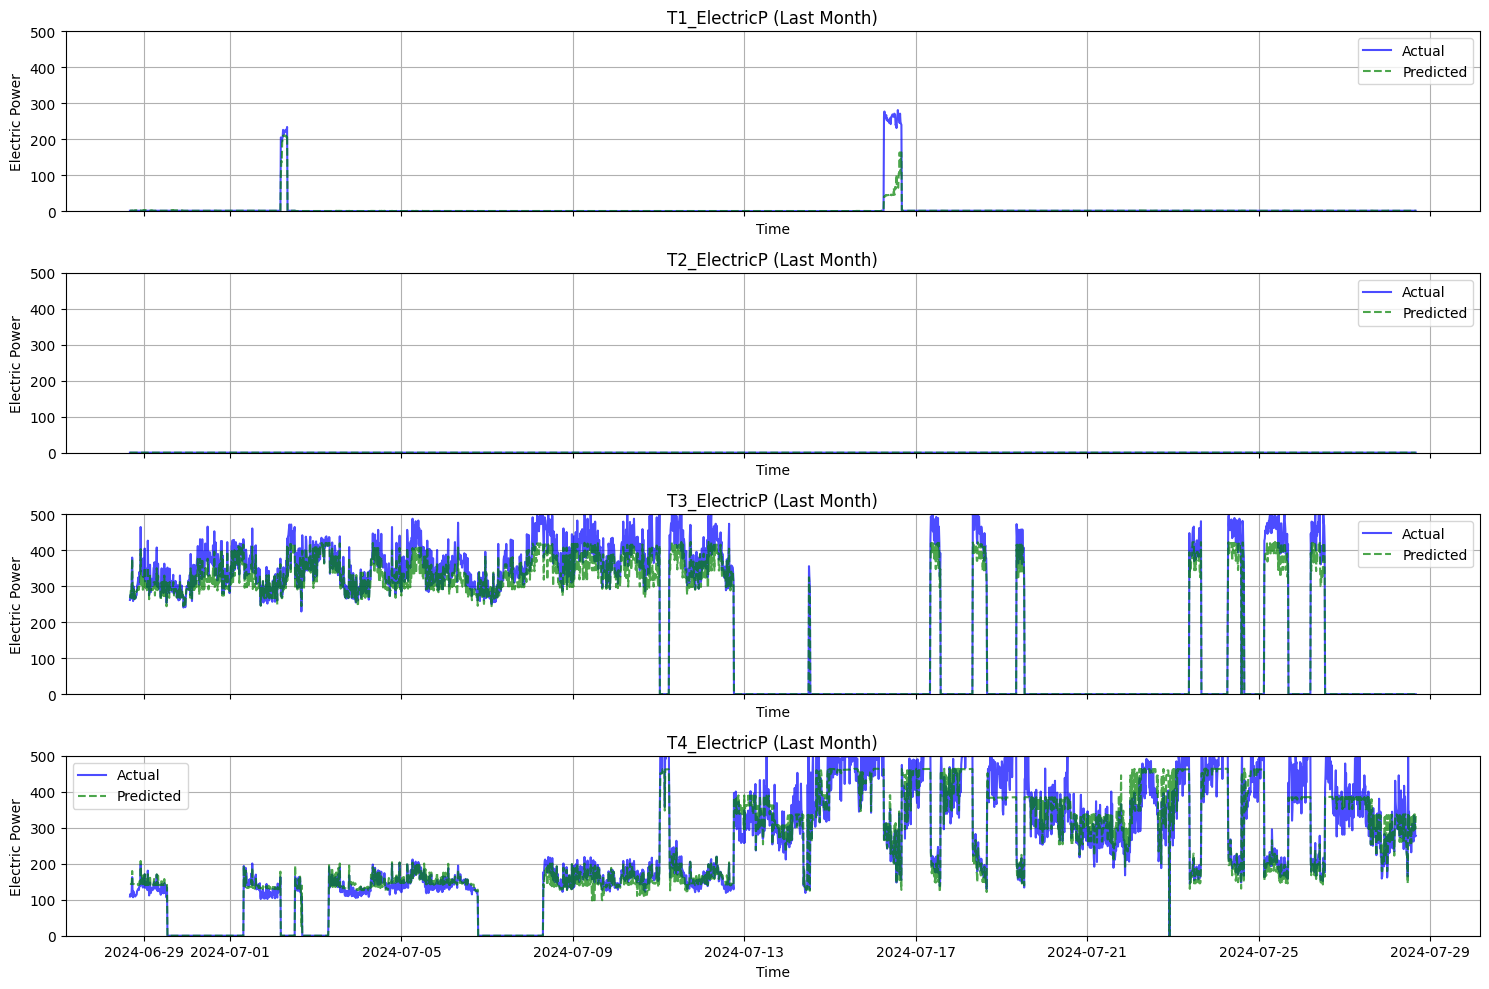

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='month')

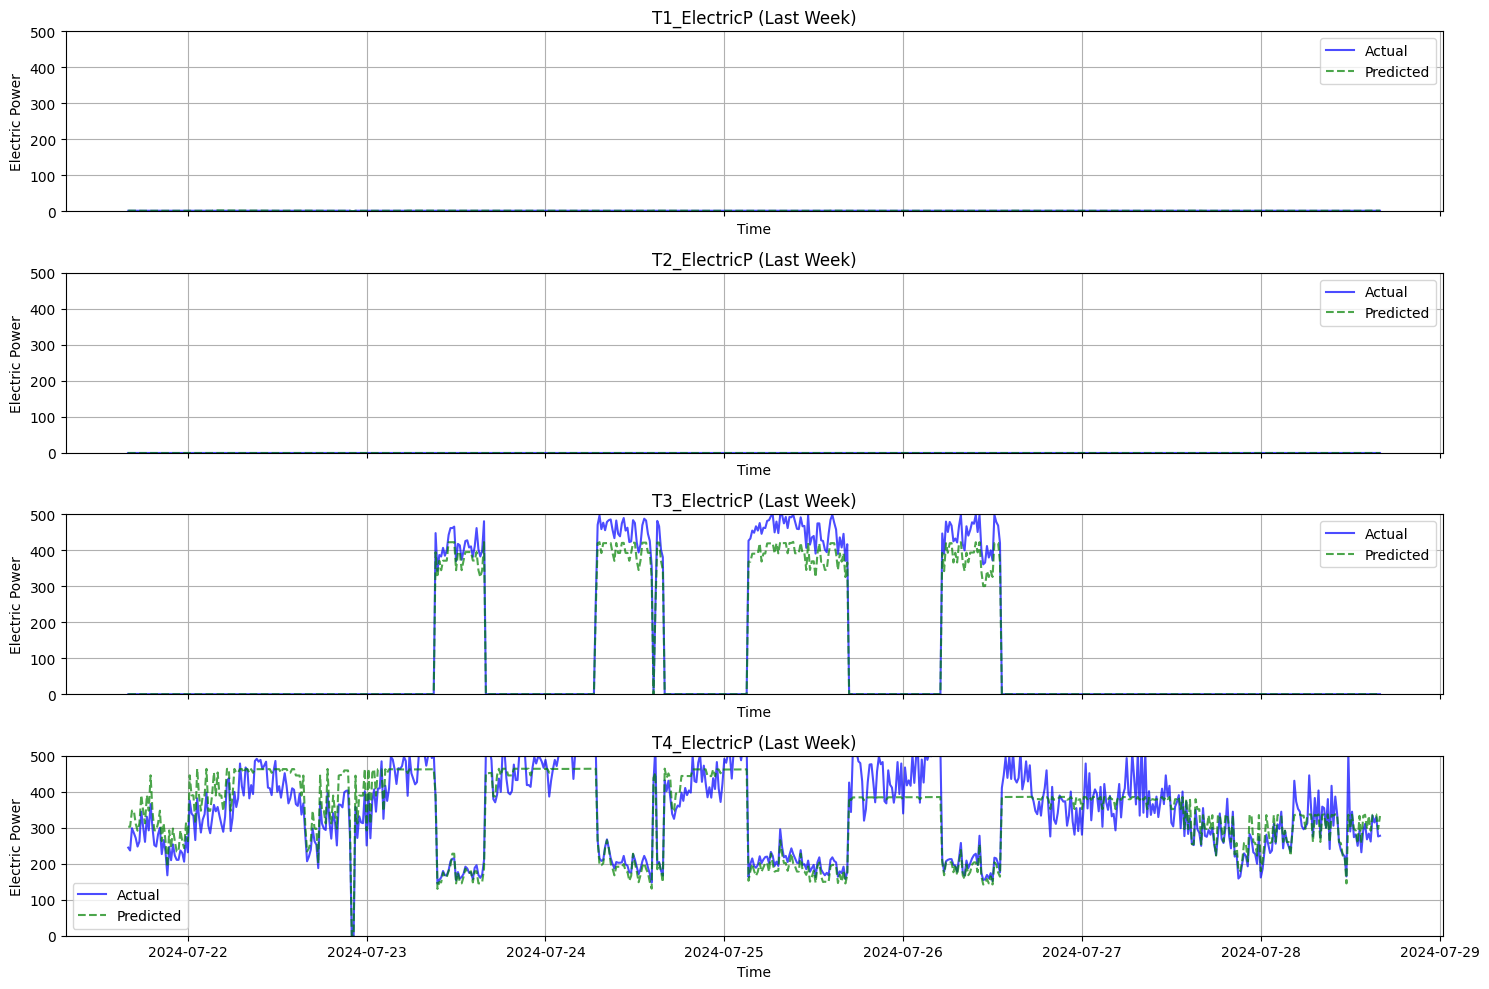

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='week')

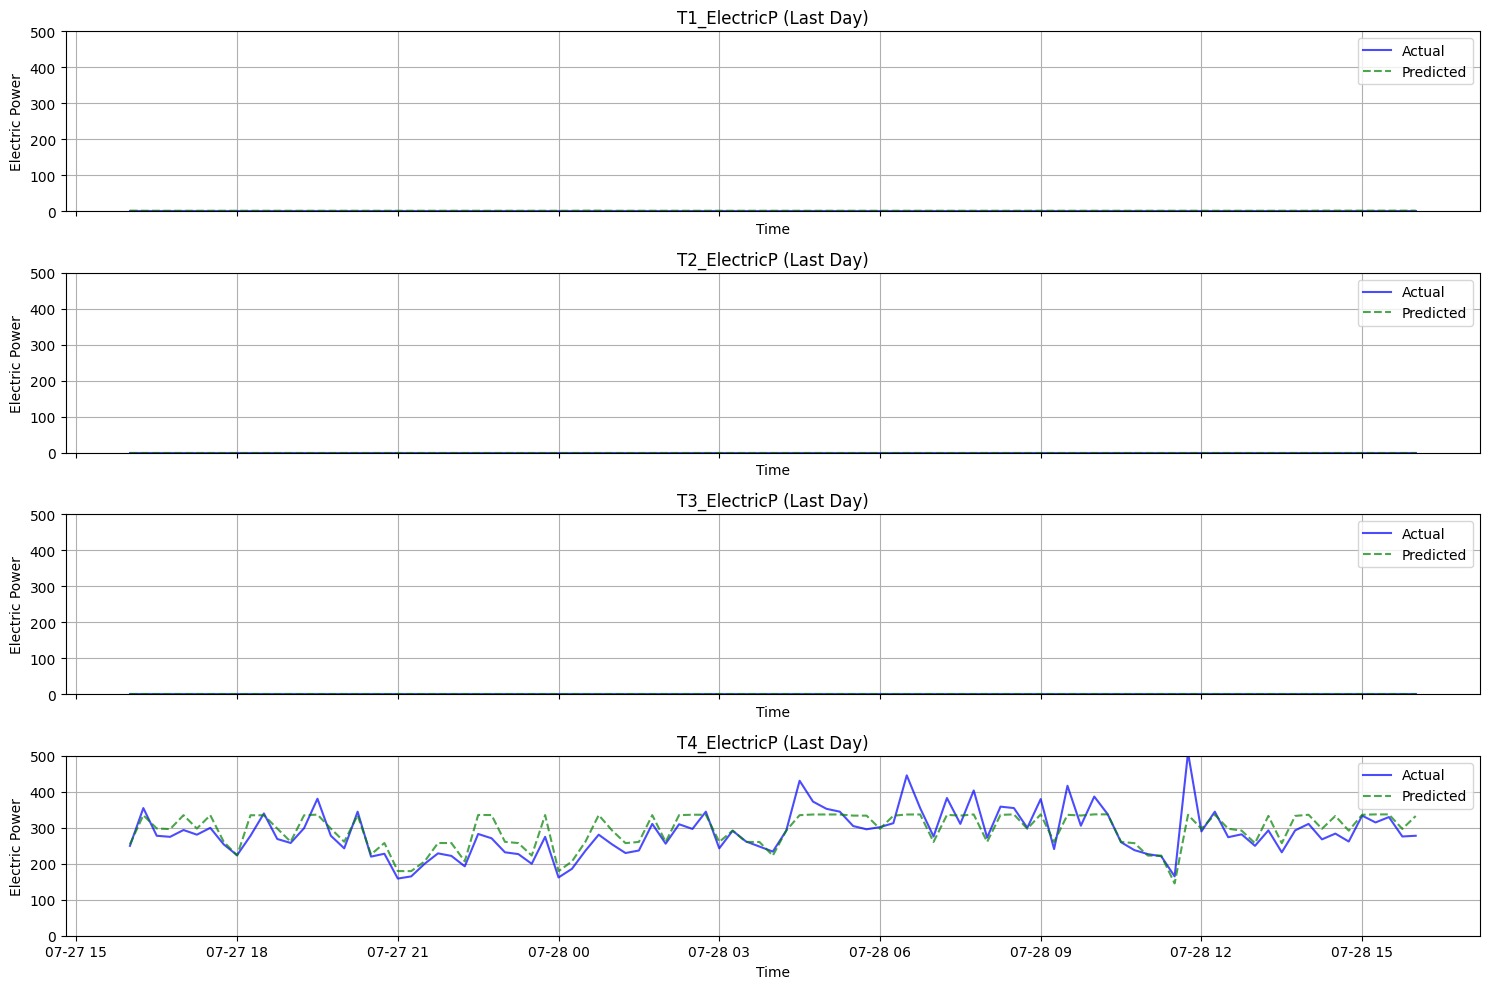

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='day')

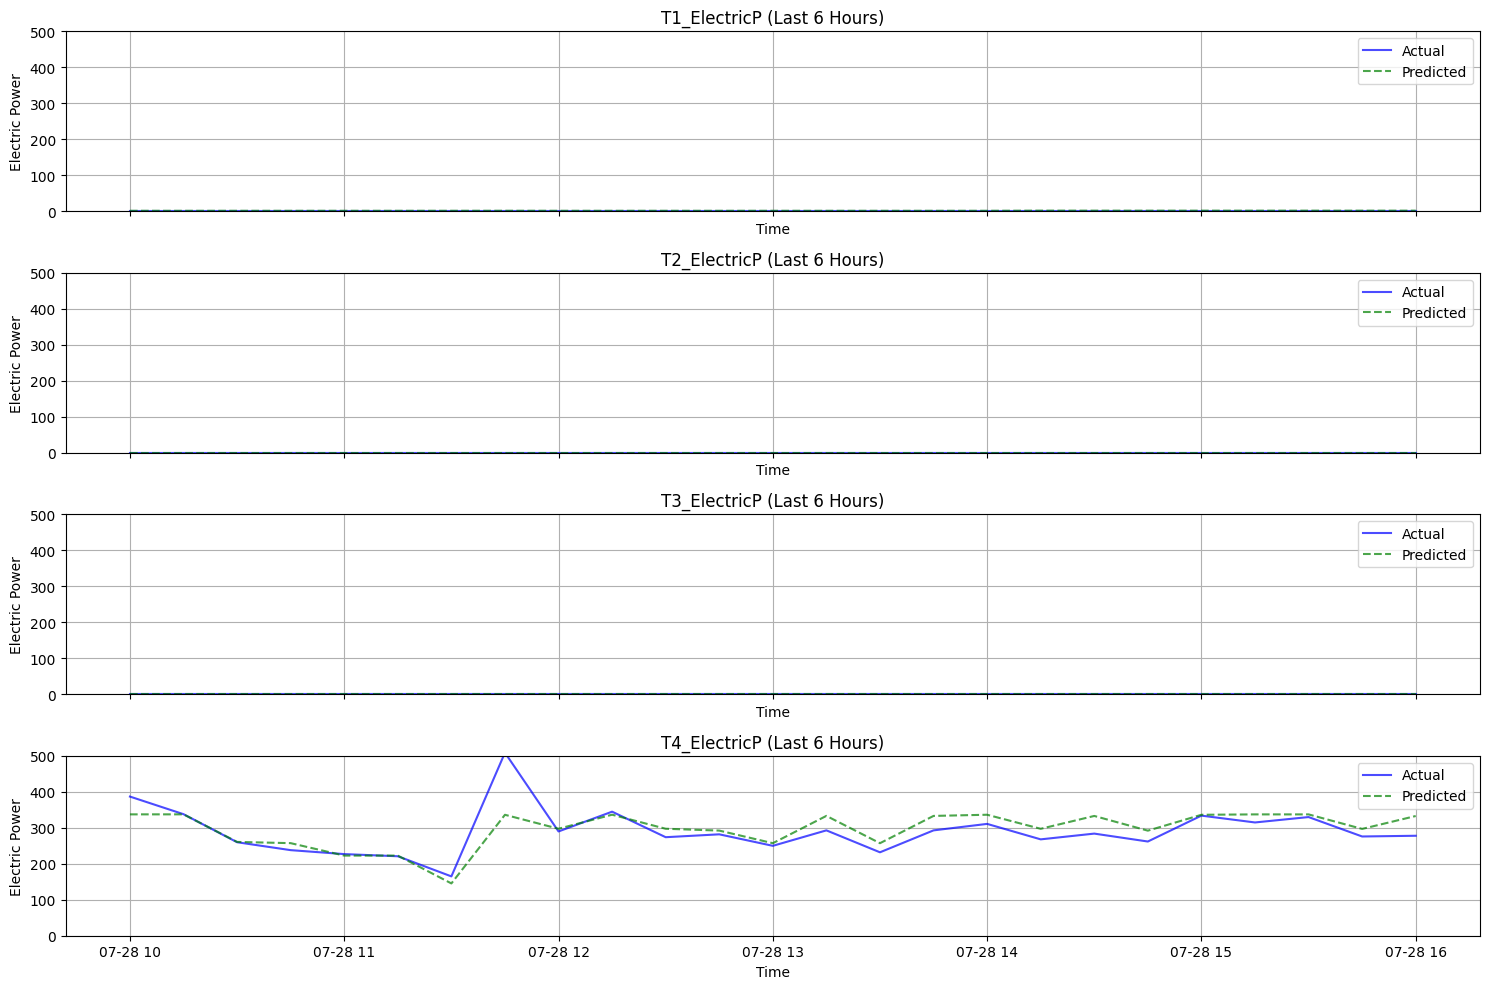

In [ ]:
# Call the function to plot all targets
plot_predictions(targets, time_frame='hour')